## MRI BRAIN TUMOR DETECTION

DATASET: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

DATASET: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection

**Import Packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00


In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch import nn
import glob
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys
from torchvision import transforms
from monai.data import DataLoader
#from monai.transforms import AddChannel, Compose, RandFlip, RandRotate, Resize, ScaleIntensity, ToTensor
#from monai.networks.nets import CNN



In [ ]:
!pip install -q keras

In [ ]:
import keras

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
import cv2
import glob

tumor = []
healthy = []

for f in glob.iglob("/content/drive/MyDrive/brain tumor/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))

    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])  # Corrected merging of channels
    tumor.append(img)

for f in glob.iglob("/content/drive/MyDrive/brain tumor/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))

    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])  # Corrected merging of channels
    healthy.append(img)


In [ ]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy,tumor))

In [ ]:
All.shape

(3005, 128, 128, 3)

In [ ]:
healthy.shape

(1573, 128, 128, 3)

In [ ]:
tumor.shape

(1432, 128, 128, 3)

 **BRAIN MRI IMAGE**

In [ ]:
def plot_random(healthy, tumor, num=5):
    if num == 0:
        print("Number of images to plot cannot be zero.")
        return

    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16, 9))  # Adjust the figure size for horizontal layout
    for i in range(num):
        plt.subplot(2, num, i + 1)  # Assuming you want a 2-row layout
        plt.imshow(healthy_imgs[i])
        plt.title('Healthy')
        plt.axis('on')  # show axis

        plt.subplot(2, num, num + i + 1)  # Plot tumor images in the second row
        plt.imshow(tumor_imgs[i])
        plt.title('Tumor')
        plt.axis('on')  # show axis

    plt.show()

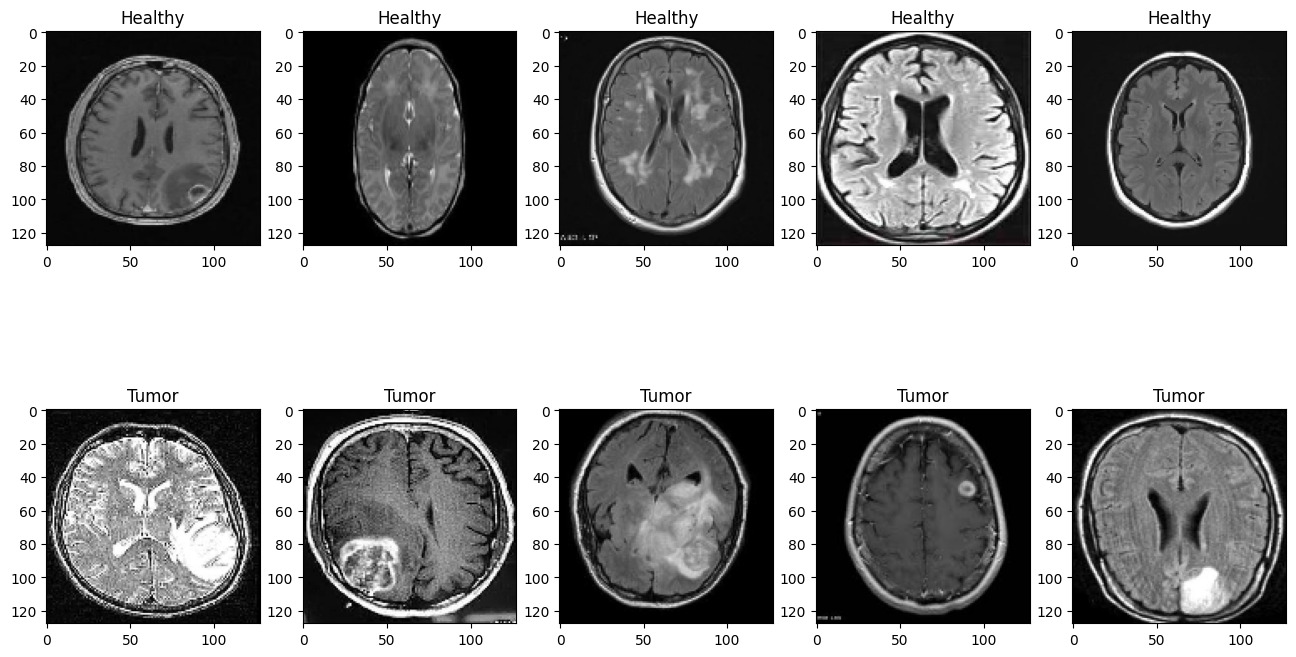

In [ ]:
plot_random(healthy, tumor)

# **Creating MRI Dataset class - TORCH**

In [ ]:
class Dataset(object):
  def __getitem__(self,index):
    raise NotImplementedError
  def __len__(self):
    raise NotImplementedError
  def __add__(self,other):
    return ConcatDataset([self,other])

In [ ]:
import cv2
import numpy as np
import glob
from torch.utils.data import Dataset

class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        for f in glob.iglob("/content/drive/MyDrive/brain tumor/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b]) # Corrected merging of channels
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumor.append(img)
        for f in glob.iglob("/content/drive/MyDrive/brain tumor/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthy.append(img)
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        print("Length of tumor labels:", len(tumor_label))
        print("Length of healthy labels:", len(healthy_label))
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        print("Length of images array:", len(self.images))
        print("Length of labels array:", len(self.labels))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0

mri = MRI()



Length of tumor labels: 1432
Length of healthy labels: 1573
Length of images array: 3005
Length of labels array: 3005


In [ ]:
len(mri)

3005

In [ ]:
mri[56]

{'image': array([[[ 14.,  14.,  14., ...,  10.,  10.,  10.],
         [ 10.,  19.,  19., ...,  15.,  15.,  11.],
         [ 11.,  11.,  22., ...,  16.,  16.,  16.],
         ...,
         [ 72.,  72.,  74., ...,  13.,  13.,  13.],
         [  7.,   7.,   7., ...,  75.,  67.,  67.],
         [ 67.,  72.,  72., ...,  70.,  70.,  83.]],
 
        [[ 83.,  83.,  82., ...,  15.,  15.,  15.],
         [ 17.,  17.,  17., ...,  70.,  80.,  80.],
         [ 80., 131., 131., ...,  89.,  89.,  78.],
         ...,
         [ 87., 114., 114., ..., 228., 228., 228.],
         [228., 228., 240., ...,  14.,  14.,  14.],
         [ 12.,  12.,  12., ...,  60.,  71.,  71.]],
 
        [[ 71.,  85.,  85., ..., 230., 230., 227.],
         [227., 227., 238., ...,  14.,  14.,  14.],
         [ 12.,  12.,  12., ...,  26.,  49.,  49.],
         ...,
         [ 12.,  12.,  12., ...,  87.,  35.,  35.],
         [ 35.,  29.,  29., ...,  21.,  21.,  38.],
         [ 38.,  38.,  52., ...,  11.,  11.,  11.]]], dtype

In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()

Length of tumor labels: 1432
Length of healthy labels: 1573
Length of images array: 3005
Length of labels array: 3005


# WITHOUT DATA **LOADER**

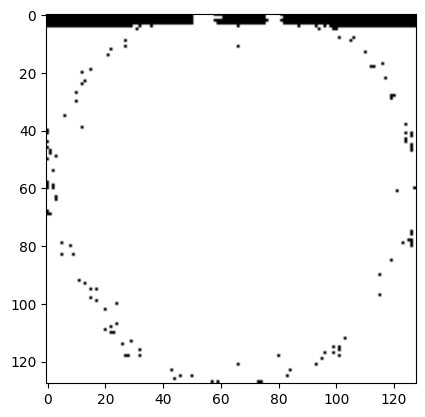

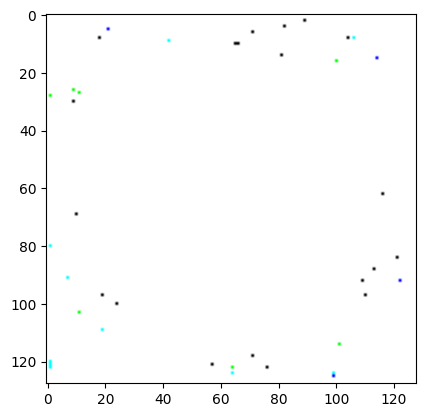

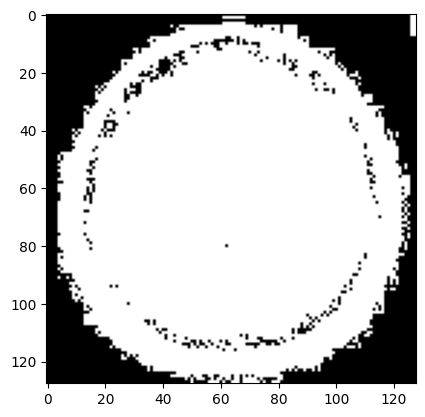

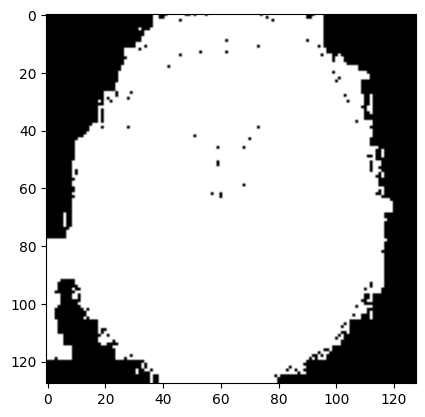

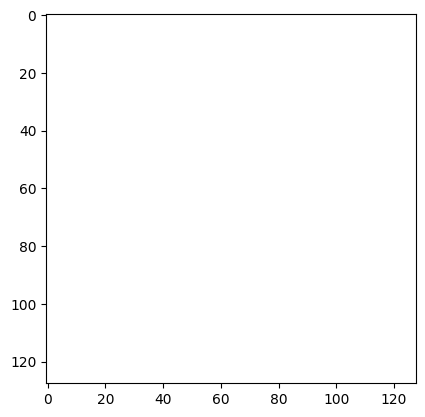

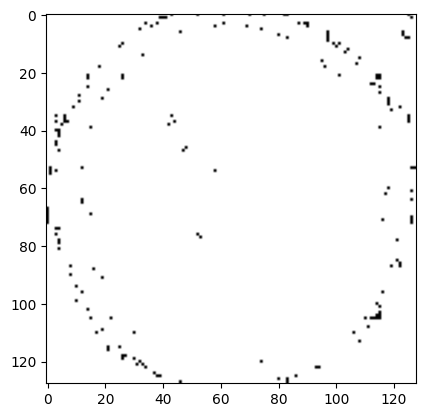

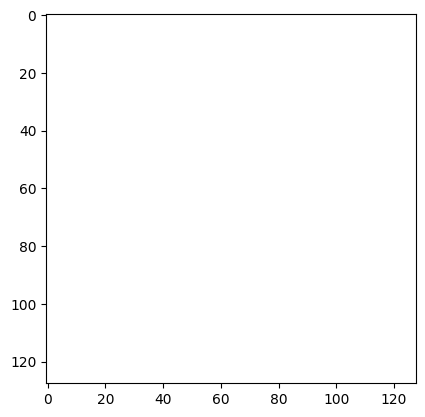

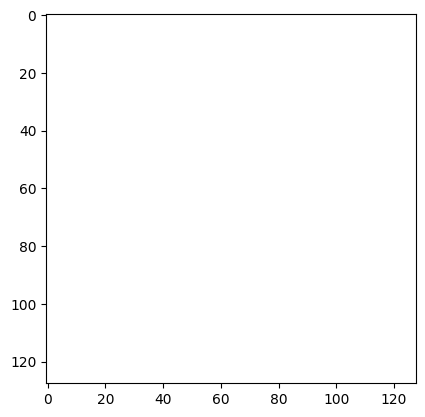

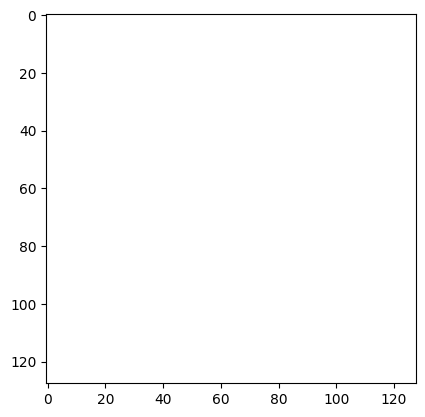

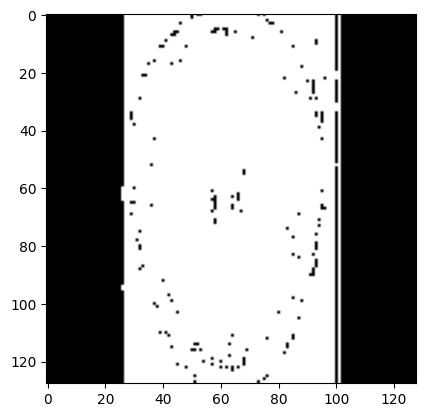

In [ ]:
import random

index = list(range(len(mri)))
random.shuffle(index)

# Display a limited number of images
num_images_to_display = 10
for idx in index[:num_images_to_display]:
    sample = mri[idx]
    img = sample['image']
    label = sample['label']
    img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
    plt.imshow(img)
    plt.show()


# **DATALOADER**

In [ ]:
dataloader = DataLoader(mri)

In [ ]:
dataset = MRI()

Length of tumor labels: 1432
Length of healthy labels: 1573
Length of images array: 3005
Length of labels array: 3005


In [ ]:
# Create a dataloader
dataloader = DataLoader(mri, batch_size=10, shuffle=True)

In [ ]:
for sample in dataloader:
    img = sample['image'] #.squeeze()
    print(img.shape)
    sys.exit()
    #img = img.reshape(img.shape[1],img.shape[2],img.shape[0])
    #plt.imshow(img)
    #plt.show()

torch.Size([10, 3, 128, 128])


SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# **MAKING CNN MODEL**

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.Dropout(p=0.2),  # Add dropout here
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.Dropout(p=0.2),  # Add dropout here
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.BatchNorm2d(16)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.conv_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

**Logic behind number**

Formula:

#n(out)= ceil |{[n(in)+2p-f]/5}+1|

In [ ]:
model = CNN()

In [ ]:
model

CNN(
  (conv_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Tanh()
    (6): Dropout(p=0.2, inplace=False)
    (7): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
model.conv_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [ ]:
model.conv_model[0].weight

Parameter containing:
tensor([[[[-3.3253e-03,  8.8745e-02, -1.0264e-01, -8.5335e-02, -2.4586e-02],
          [-9.1866e-02, -1.2806e-02, -5.8812e-02, -3.1185e-02, -4.7553e-02],
          [ 6.3667e-02,  3.5290e-03,  1.5039e-02,  1.2729e-02, -1.4453e-02],
          [-7.5625e-02,  9.8891e-02, -9.2596e-02,  6.7105e-02, -1.7648e-02],
          [ 9.3978e-03,  1.0403e-01, -5.7710e-03,  1.0032e-01,  1.0789e-01]],

         [[-3.9233e-03, -2.7125e-02,  9.1720e-02, -1.3506e-02, -4.3527e-02],
          [-4.0231e-02,  7.9407e-02, -9.1893e-02,  5.5101e-02, -1.1523e-01],
          [-8.6881e-02, -8.0318e-02,  7.5010e-02,  8.2046e-02, -5.1607e-02],
          [-8.8670e-02,  9.2253e-02,  9.5840e-02, -8.7207e-02, -2.9837e-02],
          [-1.6391e-02, -4.7657e-02,  7.8304e-02, -9.3185e-02, -9.5915e-05]],

         [[ 1.3811e-02, -1.0596e-01, -6.1020e-03,  9.0674e-02,  4.1934e-02],
          [-8.7546e-02,  8.5190e-02, -4.3888e-03,  2.6180e-02, -9.2799e-02],
          [-8.2700e-02, -1.0312e-01,  1.0825e-01, 

In [ ]:
model.conv_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [ ]:
model.conv_model[0].weight[0].shape

torch.Size([3, 5, 5])

In [ ]:
model.conv_model[0].weight[0][0]

tensor([[-0.0033,  0.0887, -0.1026, -0.0853, -0.0246],
        [-0.0919, -0.0128, -0.0588, -0.0312, -0.0476],
        [ 0.0637,  0.0035,  0.0150,  0.0127, -0.0145],
        [-0.0756,  0.0989, -0.0926,  0.0671, -0.0176],
        [ 0.0094,  0.1040, -0.0058,  0.1003,  0.1079]],
       grad_fn=<SelectBackward0>)

# LINEAR LAYER

In [ ]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
model.fc_model[0].weight.shape

torch.Size([120, 256])

# **x view(x.size(0), -1)**

In [ ]:
x = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [ ]:
x = x.reshape((2,2,2,2))

In [ ]:
x

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]]],


        [[[ 9, 10],
          [11, 12]],

         [[13, 14],
          [15, 16]]]])

# **torch.tensor vs. torch.cuda.tensor**

In [ ]:

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpu_tensor = torch.rand(10)
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())

print (gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.8999, 0.0127, 0.4238, 0.8460, 0.5806, 0.2820, 0.2061, 0.9119, 0.0868,
        0.0011]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.8999, 0.0127, 0.4238, 0.8460, 0.5806, 0.2820, 0.2061, 0.9119, 0.0868,
        0.0011]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([8.0980e-01, 1.6084e-04, 1.7963e-01, 7.1571e-01, 3.3715e-01, 7.9529e-02,
        4.2485e-02, 8.3149e-01, 7.5380e-03, 1.2099e-06])


In [ ]:
class MRI(Dataset):

  mri_dataset = MRI()
  mri_dataset.normalize()

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  model = CNN().to(device)


Length of tumor labels: 1432
Length of healthy labels: 1573
Length of images array: 3005
Length of labels array: 3005


In [ ]:
dataloader = DataLoader(mri, batch_size=32, shuffle=False)


In [ ]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():
  for D in dataloader:
    image = D['image'].to(device)
    label = D['label'].to(device)
    y_hat = model(image)
    outputs.append(y_hat.cpu().detach().numpy())
    y_true.append(label.cpu().detach().numpy())

In [ ]:
print("Length of outputs:", len(outputs))
print("Length of y_true:", len(y_true))


Length of outputs: 94
Length of y_true: 94


In [ ]:
for out in outputs:
    print("Output shape:", out.shape)

for y in y_true:
    print("True label shape:", y.shape)


Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output shape: (32, 1)
Output sha

In [ ]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [ ]:
def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [ ]:
accuracy_score(y_true,threshold(outputs))

0.5234608985024959

# **Visual Representation**

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

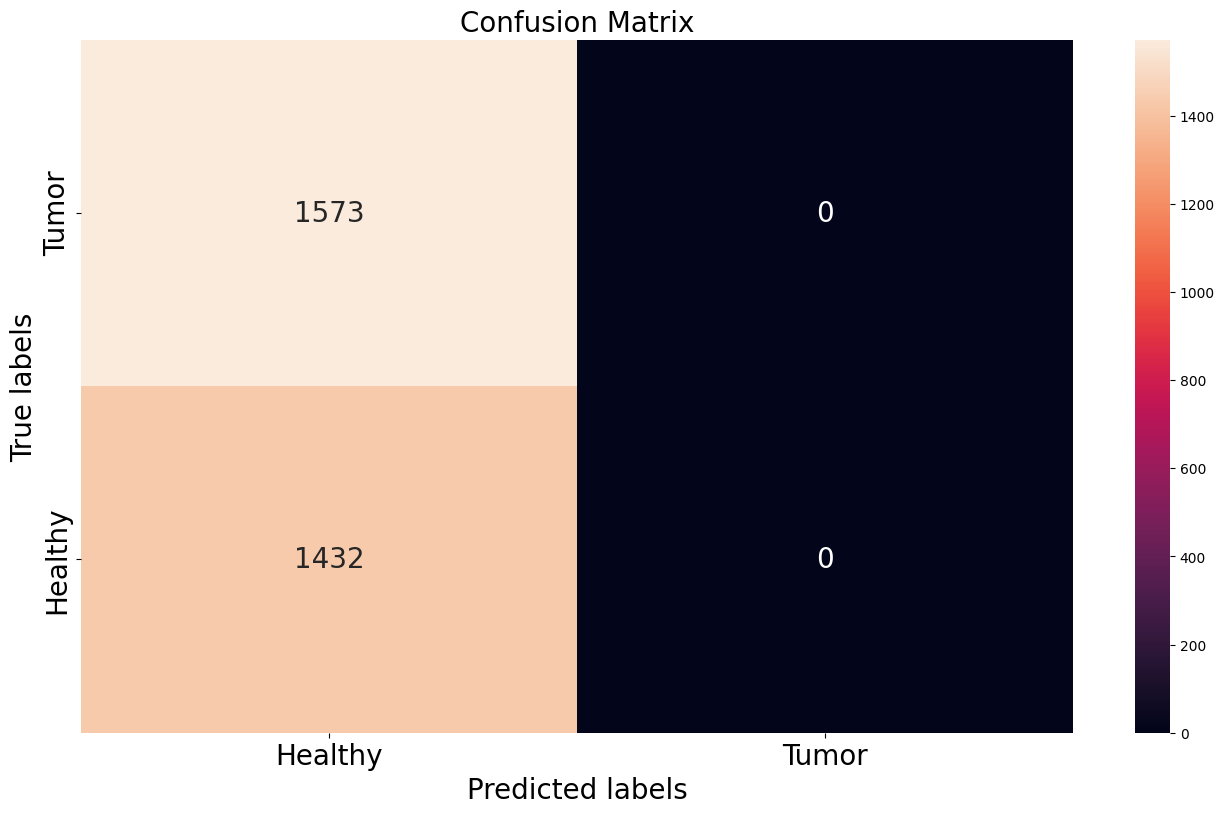

In [ ]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

#labels, title and ticks

ax.set_xlabel('Predicted labels', fontsize=20)

ax.set_ylabel('True labels', fontsize=20)

ax.set_title('Confusion Matrix', fontsize=20)

ax.xaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'], fontsize=20)


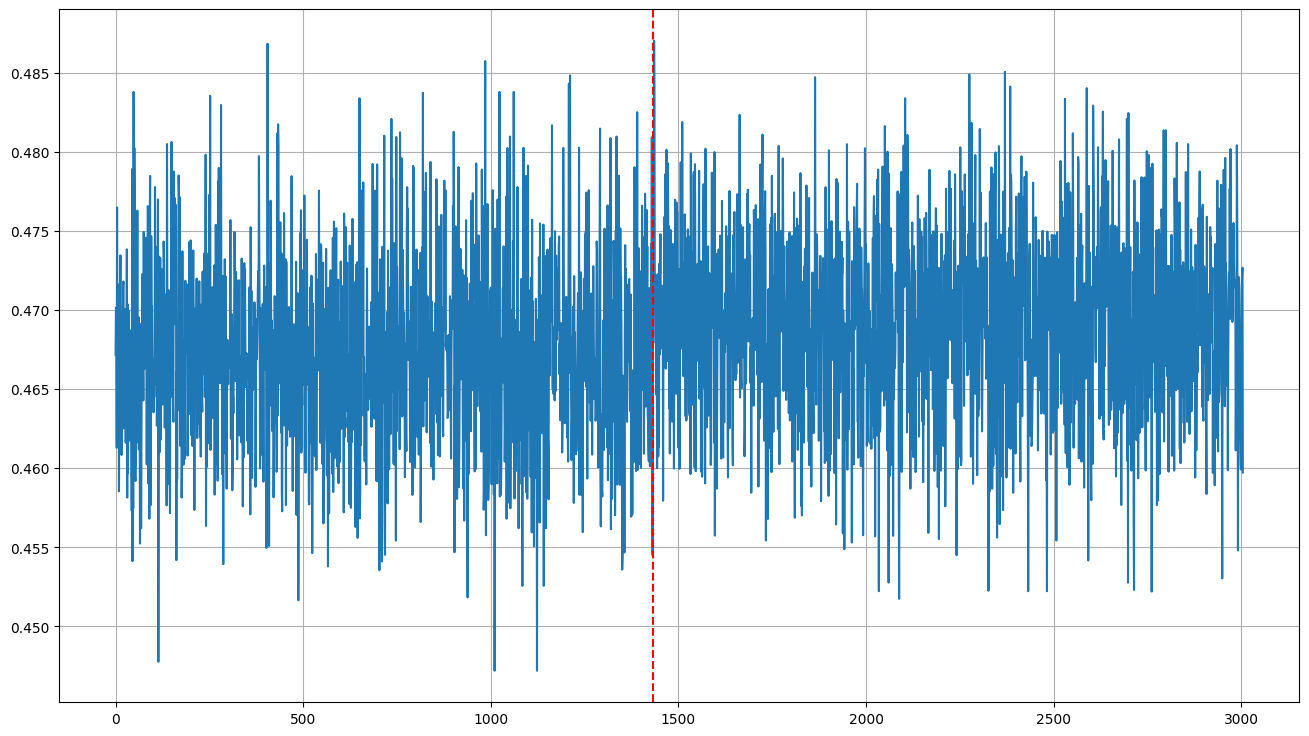

In [ ]:
 plt.figure(figsize=(16,9))
 plt.plot(outputs)
 plt.axvline(x=len(tumor),color='r',linestyle ='--')
 plt.grid()

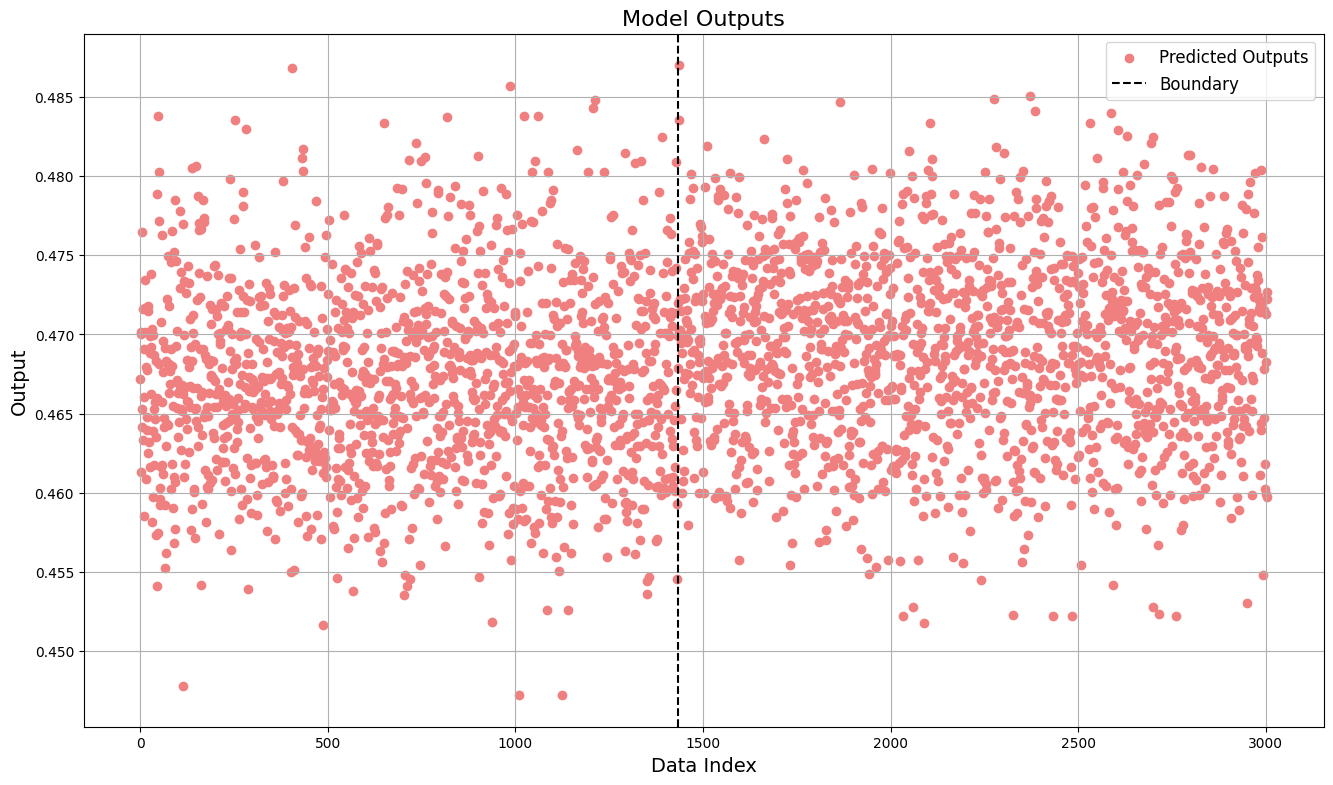

In [ ]:
plt.figure(figsize=(16, 9))

# Plot outputs as a scatter plot with a light green color
plt.scatter(range(len(outputs)), outputs, color='lightcoral', label='Predicted Outputs')

# Add vertical line to indicate boundary between tumor and healthy data
plt.axvline(x=len(tumor), color='black', linestyle='--', label='Boundary')

plt.grid()
plt.xlabel('Data Index', fontsize=14)
plt.ylabel('Output', fontsize=14)
plt.title('Model Outputs', fontsize=16)
plt.legend(fontsize=12)
plt.show()


# **Training Model Efficient**

In [ ]:
eta = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()


CNN(
  (conv_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Tanh()
    (6): Dropout(p=0.2, inplace=False)
    (7): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
EPOCH = 100

In [ ]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)

        # Define loss function
        error = nn.BCELoss()

        # Calculate loss
        loss = torch.sum(error(y_hat.squeeze(), label))

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print("Train Epoch: {}\tloss: {:.6f}".format(epoch+1, np.mean(losses)))


Train Epoch: 10	loss: 0.357962
Train Epoch: 20	loss: 0.245485
Train Epoch: 30	loss: 0.142951
Train Epoch: 40	loss: 0.071281
Train Epoch: 50	loss: 0.042696
Train Epoch: 60	loss: 0.021401
Train Epoch: 70	loss: 0.010286
Train Epoch: 80	loss: 0.004432
Train Epoch: 90	loss: 0.005339
Train Epoch: 100	loss: 0.004501


# Feature Map

In [ ]:
model

CNN(
  (conv_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Tanh()
    (6): Dropout(p=0.2, inplace=False)
    (7): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
no_of_layers = 0
conv_layer =[]

In [ ]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): Dropout(p=0.2, inplace=False)
   (3): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (5): Tanh()
   (6): Dropout(p=0.2, inplace=False)
   (7): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
   (5): Sigmoid()
 )]

In [ ]:
# Initialize variables
no_of_layers = 0
conv_layers = []

# Iterate through the children modules of the model
for child in model.children():
    if isinstance(child, nn.Sequential):
        # If the child module is a Sequential container, iterate through its children
        for layer in child.children():
            if isinstance(layer, nn.Conv2d):
                # If the layer is a Conv2d layer, increment the count and append it to the list
                no_of_layers += 1
                conv_layers.append(layer)


In [ ]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

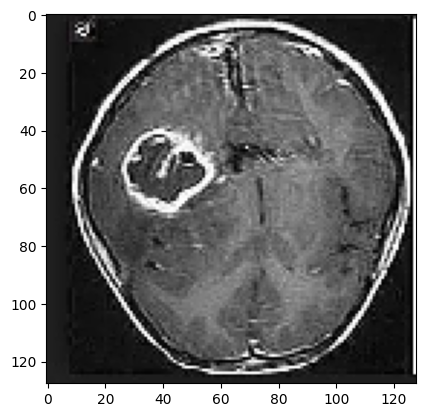

In [ ]:
img = mri_dataset[250]['image']
plt.imshow(img.reshape(128,128,3))

In [ ]:
img = torch.from_numpy(img).to(device)

In [ ]:
img.shape

torch.Size([3, 128, 128])

In [ ]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [ ]:
results =[conv_layers[0](img)]
for i in range (1,len(conv_layers)):
  results.append(conv_layers[1](results[-1]))
outputs = results

In [ ]:
outputs[1].shape

torch.Size([1, 16, 120, 120])

In [ ]:
model

CNN(
  (conv_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): Tanh()
    (6): Dropout(p=0.2, inplace=False)
    (7): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Layer 1


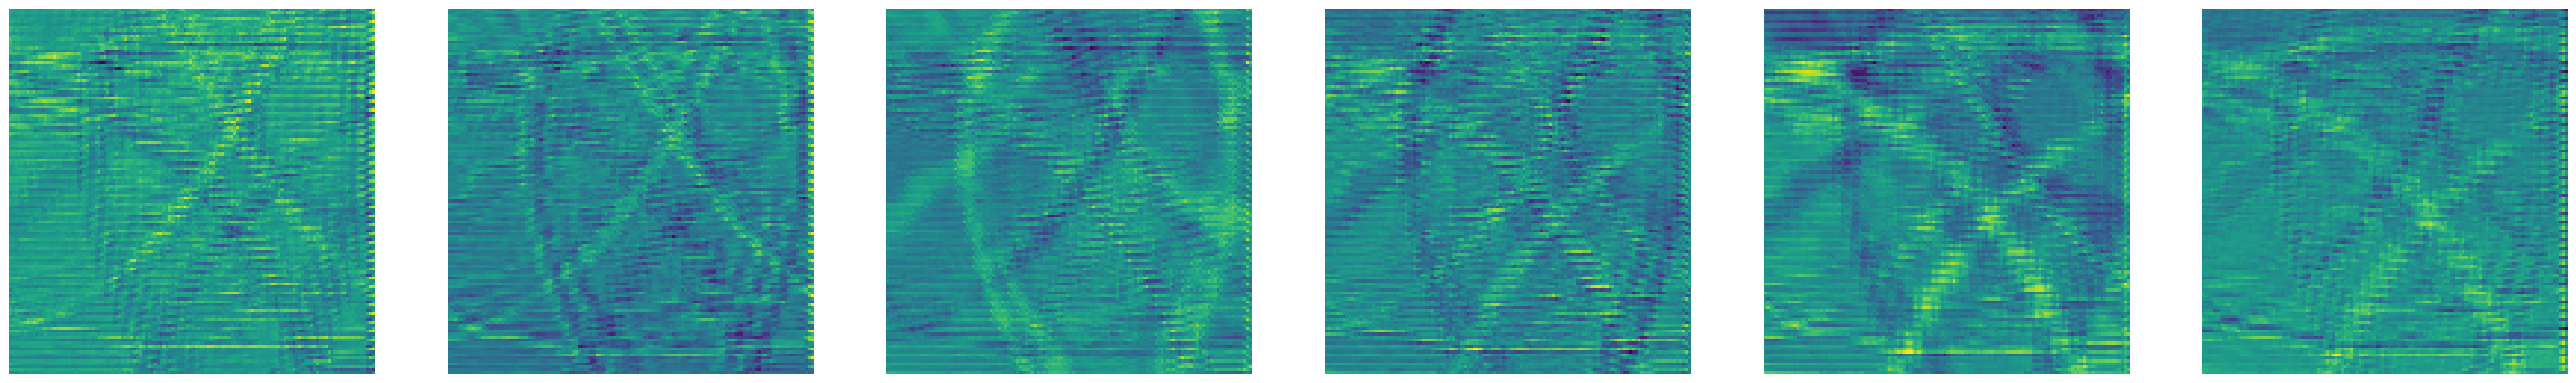

Layer 2


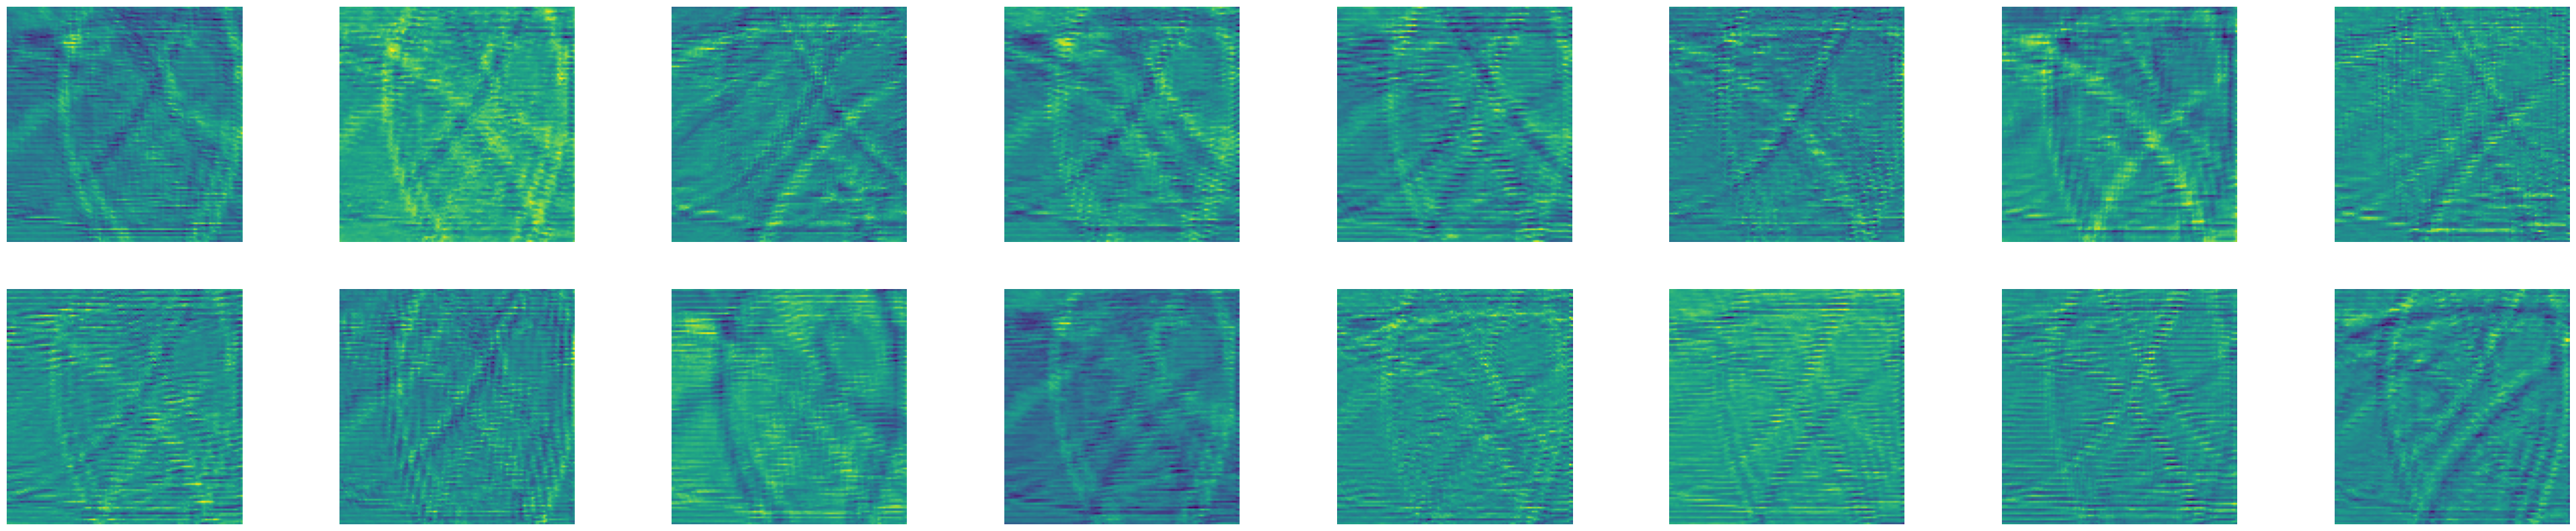

In [ ]:
import matplotlib.pyplot as plt

num_layers_to_visualize = len(outputs)
num_columns = 8
num_rows = (num_layers_to_visualize + num_columns - 1) // num_columns
for num_layer in range(num_layers_to_visualize):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer", num_layer+1)

    num_outputs = len(layer_viz)  # Number of outputs in the current layer

    num_rows_curr = (num_outputs + num_columns - 1) // num_columns

    for i, f in enumerate(layer_viz):
        plt.subplot(num_rows_curr, num_columns, i+1)
        plt.imshow(f.detach().cpu().numpy(), cmap='viridis')
        plt.axis("off")

    plt.show()
    plt.close()


# **Check Overfitting**

In [ ]:
from sklearn.model_selection import train_test_split

class MRI(Dataset):
    def __init__(self, mode='train'):
        self.mode = mode
        self.images = None
        self.labels = None
        self.x_train, self.x_val, self.y_train, self.y_val = None, None, None, None
        self.load_data()

    def load_data(self):
        tumor = []
        healthy = []

        for f in glob.iglob("/content/drive/MyDrive/brain tumor/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumor.append(img)

        for f in glob.iglob("/content/drive/MyDrive/brain tumor/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthy.append(img)

        # Convert lists to numpy arrays
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        # Generate labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenate images and labels
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

        # Split data into training and validation sets
        self.x_train, self.x_val, self.y_train, self.y_val = \
            train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        if self.mode == 'train':
            return self.x_train.shape[0]
        elif self.mode == 'val':
            return self.x_val.shape[0]

    def __getitem__(self, index):
        if self.mode == 'train':
            sample = {'image': self.x_train[index], 'label': self.y_train[index]}
        elif self.mode == 'val':
            sample = {'image': self.x_val[index], 'label': self.y_val[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0


In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()


In [ ]:
train_dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle= True)
val_dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle= False)

In [ ]:
model = CNN()


In [ ]:
eta=0.0001
optimizer=torch.optim.Adam(model.parameters(), lr=eta)

In [ ]:
for epoch in range(1, num_epochs):
    # Training phase
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        data = batch['image'].to(device)
        label = batch['label'].to(device)
        output = model(data)
        output = output.squeeze()  # Squeeze the output tensor to remove the extra dimension
        loss = loss_function(output, label)  # Use the defined loss function
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for batch in val_dataloader:
            data = batch['image'].to(device)
            label = batch['label'].to(device)
            output = model(data)
            output = output.squeeze()  # Squeeze the output tensor
            val_loss = loss_function(output, label)  # Use the defined loss function
            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    print(f'Epoch [{epoch}/{num_epochs}], Validation Loss: {average_val_loss:.4f}')


In [ ]:
epoch_train_loss =[]
epoch_val_loss = []

In [ ]:
for epoch in range(1, 200):
    train_losses = []
    model.train()
    mri_dataset.mode = 'train'

    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image']
        label = D['label']
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))

        # Add L2 regularization
        l2_lambda = 0.0001  # Reduced regularization strength
        l2_reg = 0.0  # Initialize regularization term
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg  # Add regularization term to the loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # Validation phase
    model.eval()
    mri_dataset.mode = 'val'
    val_losses = []
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image']
            label = D['label']
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())  # Append to val_losses without backward pass

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))


Train Epoch: 10	Train loss: 0.348113	Val Loss: 0.335794
Train Epoch: 20	Train loss: 0.231814	Val Loss: 0.264172
Train Epoch: 30	Train loss: 0.184247	Val Loss: 0.224617
Train Epoch: 40	Train loss: 0.141257	Val Loss: 0.181460
Train Epoch: 50	Train loss: 0.113734	Val Loss: 0.164270
Train Epoch: 60	Train loss: 0.081455	Val Loss: 0.149415
Train Epoch: 70	Train loss: 0.060784	Val Loss: 0.119089
Train Epoch: 80	Train loss: 0.040581	Val Loss: 0.110835
Train Epoch: 90	Train loss: 0.046802	Val Loss: 0.111389
Train Epoch: 100	Train loss: 0.037929	Val Loss: 0.103691
Train Epoch: 110	Train loss: 0.022944	Val Loss: 0.114370
Train Epoch: 120	Train loss: 0.017335	Val Loss: 0.108305
Train Epoch: 130	Train loss: 0.016814	Val Loss: 0.112332
Train Epoch: 140	Train loss: 0.011421	Val Loss: 0.125537
Train Epoch: 150	Train loss: 0.009554	Val Loss: 0.117848
Train Epoch: 160	Train loss: 0.014108	Val Loss: 0.144815
Train Epoch: 170	Train loss: 0.012942	Val Loss: 0.128620
Train Epoch: 180	Train loss: 0.006089	Va

Text(0, 0.5, 'Loss')

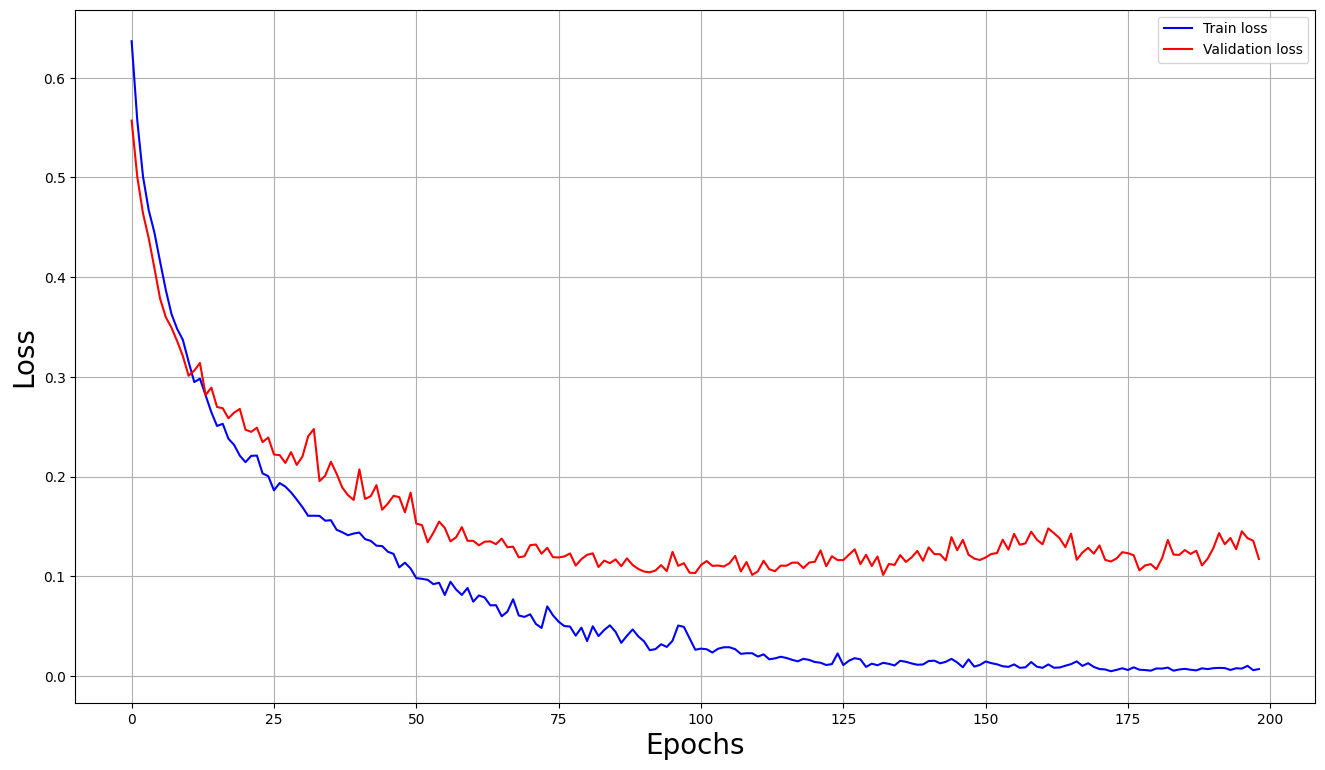

In [ ]:
plt.figure(figsize=(16,9))

plt.plot(epoch_train_loss, c='b', label='Train loss')

plt.plot(epoch_val_loss, c='r', label='Validation loss')

plt.legend()

plt.grid()

plt.xlabel('Epochs', fontsize=20)

plt.ylabel('Loss', fontsize=20)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(mri_dataset, test_size=0.2, random_state=42)

# Define a DataLoader for the test set
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_dataloader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        outputs = model(images)
        predictions = torch.round(outputs)  # Assuming your model outputs probabilities and you want binary predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.9752066115702479


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(y_true, y_pred)
print("Precision:", precision)


Precision: 0.9841269841269841


In [ ]:
from sklearn.metrics import recall_score

recall = recall_score(y_true, y_pred)
print("Recall:", recall)


Recall: 0.96875


In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)


Specificity: 0.9824561403508771
